In [1]:
import os
import numpy as np

try:
    os.makedirs("fake_files")
except:
    pass
else:
    for idx in range(15_000):
        fname = "fake_files/file_{}.npy".format(idx)
        if not os.path.exists(fname):
            np.save(fname, np.random.normal(size=100000))  
        else:
            print(idx)

# Diseño de software para cómputo científico

---
## Unidad 4: Optimización, paralelismo, concurrencia y cómputo distribuido en alto nivel.

**NO BORRAR OUTPUT**

## Concurrencia 

> se refiere a la habilidad de distintas partes de un programa, algoritmo, o problema de ser ejecutado en desorden o en orden parcial, sin afectar el resultado final. 

> Los cálculos (operaciones) pueden ser ejecutados en múltiples procesadores, o ejecutados en procesadores separados físicamente o virtualmente en distintos hilos de ejecución. 

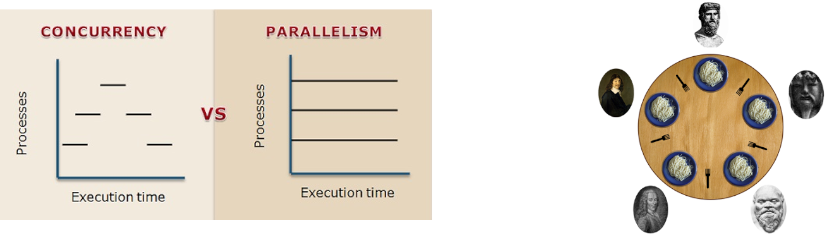

## Hilos vs Procesos

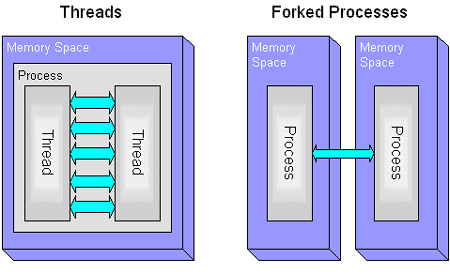

- **Hilos:**
    - Se ejecutan en el mismo proceso.
    - Comparten memoria.
- **Procesos:**
    - **NO** comparten memoria.
    - Pueden ejecutarse en diferentes procesadores.

## Qué es un sistema operativo?

Es una **colección** de programas que funciona como:

- **Una máquina extendida** (top-down): Es una abstracción sobre el hardware.
- **Un manejador de recursos** (bottom-up): Un proveedor de servicios solicitados por el software.

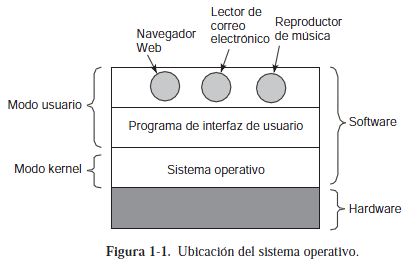

## Si nos centramos en el kernel

Linux tiene estos subsistemas

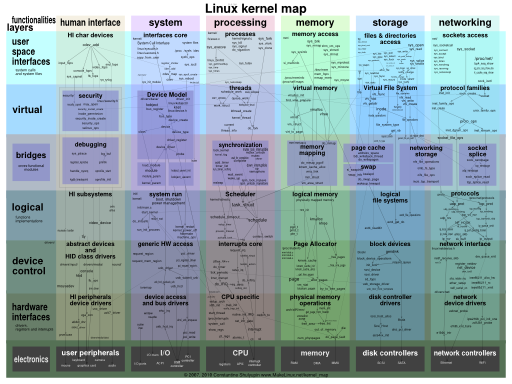

https://www.makelinux.net/kernel_map/

## Llamadas al sistema

- Es el mecanismo usado por una aplicación para solicitar un servicio al sistema operativo.

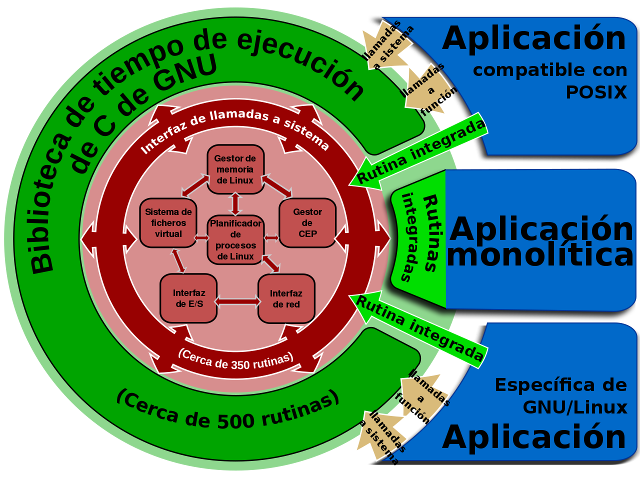

## Interrupción

Es una señal recibida por el procesador de una computadora, para indicarle que debe «interrumpir» el curso de ejecución actual y pasar a ejecutar código específico para tratar esta situación.

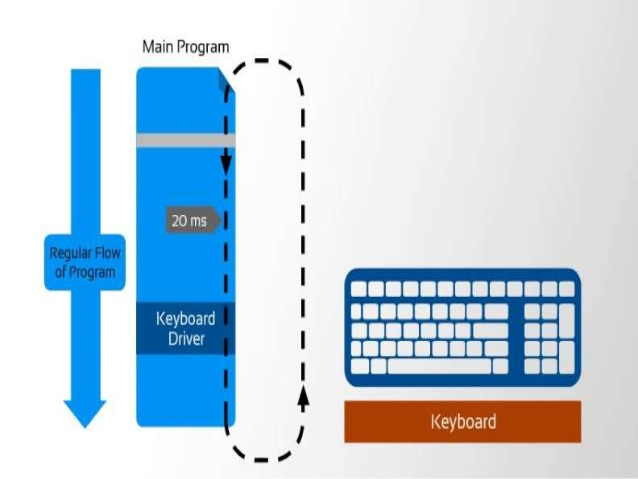

## Python - Multithreaded Programming

Es **similar** a ejecutar varios programas diferentes al mismo tiempo, pero con los siguientes beneficios:

- Comparten el mismo espacio de datos con el subproceso principal y, por lo tanto, pueden compartir información o comunicarse entre ellos fácilmente.
- No requieren mucha sobrecarga de memoria; son más baratos que los procesos.

**Problema:** EL &Ç@$!! GIL

## Global interpreter lock (GIL)

- Es un mecanismo utilizado en los intérpretes de lenguaje de computadora para sincronizar la ejecución de threads para que solo **un** subproceso nativo pueda ejecutarse a la vez.  

**Pero... WHY?**

- Mayor velocidad de los programas de un solo subproceso (no es necesario adquirir o liberar bloqueos en todas las estructuras de datos por separado).
- Fácil integración de bibliotecas C que generalmente no son seguras para subprocesos,
- Facilidad de implementación.


## Python `threading`

Vamos con un ejemplo secuencial

In [2]:
import numpy as np

In [18]:
%%time

def sts(name, nums, verbose=True):
    mean, std = np.mean(nums), np.std(nums)
    if verbose:
        print("Name {}".format(name))
        print("\t Mean {}".format(mean))
        print("\t Std {}".format(std))
    
for idx in range(10):
    name = "F{}".format(idx)
    nums = np.random.normal(size=1000)
    sts(name, nums, False)

CPU times: user 3.46 ms, sys: 0 ns, total: 3.46 ms
Wall time: 3.05 ms


## Python `threading`

In [19]:
import numpy as np
import threading

class MyThread(threading.Thread):
    def __init__(self, name, nums):
        super().__init__()
        self.name = name
        self.nums = nums
        
    def run(self):
        print("Starting ", self.name)
        self.mean = np.mean(self.nums)
        self.std = np.std(self.nums)

## Python `threading`

In [20]:
%%time
threads = []
for tidx in range(10):
    thread = MyThread(
        name="T{}".format(tidx),
        nums=np.random.normal(size=1000))
    
    thread.start()
    threads.append(thread)
    
print("-" * 10)
for thread in threads:
    thread.join()
    

Starting  T0
Starting  T1
Starting  T2
Starting  T3
Starting  Starting  T5T4
Starting  
T6Starting  T7

Starting  T8
Starting  T9
----------
CPU times: user 8.71 ms, sys: 8.44 ms, total: 17.1 ms
Wall time: 15.2 ms


### Threading que si sirve

In [6]:
%%time
def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)

for idx in range(5000):
    open_file(idx)

CPU times: user 2.46 s, sys: 2.69 s, total: 5.15 s
Wall time: 48.5 s


In [21]:
threads = []

def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
        
for idx in range(5000):
    thread = threading.Thread(target=open_file, kwargs={"idx": idx})
    threads.append(thread)

In [22]:
%%time
for thread in threads:
    thread.start()

for thread in threads:
    thread.join()

CPU times: user 12.8 s, sys: 23.8 s, total: 36.5 s
Wall time: 11.2 s


## Multiprocessing

Es un paquete que admite la generación de procesos utilizando una API similar al módulo de multithreading.



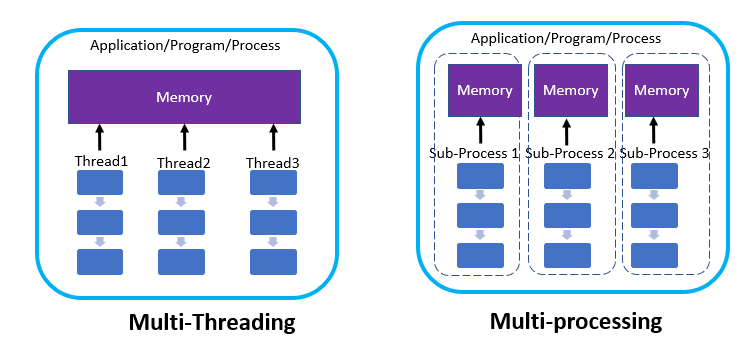

## Multiprocessing

In [23]:
import numpy as np
import multiprocessing as mp

class MyProc(mp.Process):
    def __init__(self, name, nums):
        super().__init__()
        self.name = name
        self.nums = nums
        
    def run(self):
        print("Starting ", self.name)
        self.mean = np.mean(self.nums)
        self.std = np.std(self.nums)

## Multiprocessing

In [24]:
procs = []
for pidx in range(4):
    proc = MyProc(
        name="P{}".format(pidx),
        nums=np.random.normal(size=(100, 10)))
    proc.start()
    procs.append(proc)
    
print("-" * 10)
for proc in procs:
    proc.join()
    print("\t Mean {}".format(proc.mean))
    print("\t Std {}".format(proc.std))

Starting Starting   P0
Starting  P1P2

Starting  P3
----------


AttributeError: 'MyProc' object has no attribute 'mean'

## Multiprocessing comunication

In [25]:
import numpy as np
import multiprocessing as mp

class MyProc(mp.Process):
    def __init__(self, name, nums):
        super().__init__()
        self.name = name
        self.nums = nums
        self._q = mp.Queue()
        
    def run(self):
        print("Starting ", self.name)
        self._q.put_nowait({"mean": np.mean(self.nums), 
                     "std": np.std(self.nums)})
    
    def communicate(self):
        if not hasattr(self, "_mean"):
            data = self._q.get_nowait()
            self._mean = data["mean"]
            self._std = data["std"]
    
    @property
    def mean(self):
        self.communicate()
        return self._mean
    
    @property
    def std(self):
        self.communicate()
        return self._std       

## Multiprocessing comunication

In [26]:
procs = []
for pidx in range(8):
    proc = MyProc(
        name="P{}".format(pidx),
        nums=np.random.normal(size=(100, 10)))
    proc.start()
    procs.append(proc)
    
print("-" * 10)
for proc in procs:
    proc.join()
    print("Proc {}".format(proc.name))
    print("\t Mean {}".format(proc.mean))
    print("\t Std {}".format(proc.std))

Starting Starting   P0Starting 
P1 
Starting Starting Starting  P3Starting  P2 
P5P4

 Starting 
 P7P6

----------
Proc P0
	 Mean -0.07207355674068112
	 Std 0.9844201489066317
Proc P1
	 Mean 0.02156762135837777
	 Std 1.008854038972653
Proc P2
	 Mean -0.04659324308279058
	 Std 0.9930399932069087
Proc P3
	 Mean -0.06997068310702859
	 Std 0.9616674547152713
Proc P4
	 Mean 0.030685521917173844
	 Std 0.9917723075960906
Proc P5
	 Mean 0.020757612372248657
	 Std 0.9892349002486228
Proc P6
	 Mean 0.05786504527452665
	 Std 1.0095699885845921
Proc P7
	 Mean -0.06498349246543109
	 Std 0.9766593595649548


## Joblib

![image-2.png](attachment:image-2.png)

Ayudante simple para facilitar la escritura de código paralelo legible y depurarlo rápidamente.

```bash
$ pip install joblib
```

## Joblib - Multiprocessing

In [3]:
%%time
import numpy as np
import joblib # import Parallel, delayed

def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
    return nums


with joblib.Parallel(n_jobs=-1) as parallel:
    delayed_open_file = joblib.delayed(open_file)  # una decoracion
    
    queue = (delayed_open_file(idx) for idx in range(5000))
    
    results = parallel(queue) 

CPU times: user 4.69 s, sys: 4.18 s, total: 8.87 s
Wall time: 14.5 s


## Joblib - Multi-Threading

In [16]:
%%time

import joblib # import Parallel, delayed

def open_file(idx):
    fname = "fake_files/file_{}.npy".format(idx)
    with open(fname, "rb") as fp:
        nums = np.load(fp)
    return nums


with joblib.Parallel(n_jobs=-1, prefer="multiprocessing") as parallel:
    results = parallel(
        joblib.delayed(open_file)(idx) for idx in range(5000))

CPU times: user 4.1 s, sys: 5.31 s, total: 9.41 s
Wall time: 1min 50s


In [17]:
import gc; gc.collect()

1093

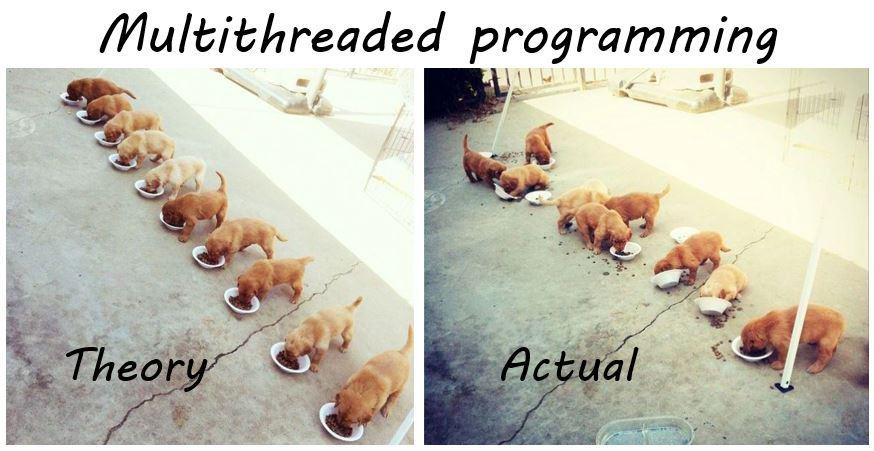

## Referencias

- https://es.wikipedia.org/wiki/Concurrencia_(inform%C3%A1tica)
- http://materias.fi.uba.ar/7508/MOS4/Operating.Systems.4th.Edi.pdf
- https://es.wikipedia.org/wiki/Interrupci%C3%B3n
- https://es.wikipedia.org/wiki/Llamada_al_sistema
- https://www.tutorialspoint.com/python/python_multithreading.htm
- https://docs.python.org/2/library/multiprocessing.html
- https://www.tutorialspoint.com/concurrency_in_python/concurrency_in_python_multiprocessing.htm
- https://joblib.readthedocs.io/en/latest/